In [1]:
import pickle as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [107]:
def jaccard_distance(x, y):
    return 1 - len(set(x).intersection(y)) / len(set(x).union(y))

def results_per_group(results, group=None):
    if group is None:
        return np.mean([np.mean([results_f[uid] for uid in results_f]) for idx, results_f in enumerate(results)])
    else:
        return np.mean([np.mean([results_f[uid] for uid in group[idx] if uid in results_f]) for idx, results_f in enumerate(results)])

def recgap(x, y):
    return np.abs(np.array(x) - np.array(y))

def _gap(recommendation_list, item_popularity, user_profile_popularity):
    arp = np.mean([item_popularity.loc[str(iid)] for iid in recommendation_list])
    return (arp - user_profile_popularity) / user_profile_popularity

def _compute_gap(dirpath, item_popularity, user_profile_popularity, impacted_users=None):
    files = sort_files(dirpath)
    gaps = []
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            gap = dict()
            for uid, recs in recommendation_list.items():
                if uid not in impacted_users[idx]:
                    continue
                gap[uid] = _gap(recommendation_list=recs, item_popularity=item_popularity, user_profile_popularity=user_profile_popularity[uid])
            gaps.append(gap)
        else:
            gap = dict()
            for uid, recs in recommendation_list.items():
                gap[uid] = _gap(recommendation_list=recs, item_popularity=item_popularity, user_profile_popularity=user_profile_popularity[uid])
            gaps.append(gap)

    return gaps

def sort_files(path):
    base, dataset_name, model_name, eps = path.split(sep="/")
    files = []
    for file in os.listdir(path):
        if file.endswith(".pkl"):
            files.append(file)

    LEN_PREFIX = len(model_name)+1
    LEN_SUFFIX = len(".pkl")
    timestamps = [filename[LEN_PREFIX:-LEN_SUFFIX] for filename in files]
    sorted_timestamps = sorted(timestamps)
    sorted_files = [model_name + "-" + timestamp + ".pkl" for timestamp in sorted_timestamps]

    return sorted_files

def _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=None):
    cut = int(len(item_popularity) * 0.8)
    tail_items = set(item_popularity.sort_values(ascending=True).iloc[:cut].index.tolist())

    recall, ndcg, arp, aft = dict(), dict(), dict(), dict()
    for uid, recs in recommendation_list.items():
        if impacted_users is not None:
            if uid not in impacted_users:
                continue

        recall[uid] = len(groundtruth.loc[uid].intersection([str(iid) for iid in recs])) / len(groundtruth.loc[uid])

        dcg = 0.0
        idcg = 0.0
        for pos in range(1, len(recs)+1):
            item_at_i = str(recs[pos-1])
            rel_i = item_at_i in groundtruth.loc[uid]
            dcg += rel_i / np.log2(pos + 1)
            idcg += 1 / np.log2(pos + 1)
        ndcg[uid] = dcg / idcg
        arp[uid] = np.mean([item_popularity.loc[str(item_id)] for item_id in recs])
        #aft[uid] = len(tail_items.intersection([str(iid) for iid in recs])) / len(recs)
        aft[uid] = len(tail_items.intersection([str(iid) for iid in recs])) / len(recs)

    return recall, ndcg, arp, aft


def _analyze_recommendations(dirpath, item_popularity, groundtruth, impacted_users=None):
    files = sort_files(dirpath)
    recalls, ndcgs, arps, afts = [], [], [], []
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=impacted_users[idx])
        else:
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth)

        recalls.append(recall)
        ndcgs.append(ndcg)
        arps.append(arp)
        afts.append(aft)

    return recalls, ndcgs, arps, afts

def _get_impacted_users(dirpath_nodp, dirpath_dp):
    files_nodp = sort_files(dirpath_nodp)
    files_dp = sort_files(dirpath_dp)

    impacted_users, frac_impacted_users, avg_dist = [], [], []
    for file_nodp, file_dp in zip(files_nodp, files_dp):
        with open(dirpath_nodp + "/" + file_nodp, "rb") as f:
            recommendation_list_nodp = pl.load(f)

        with open(dirpath_dp + "/" + file_dp, "rb") as f:
            recommendation_list_dp = pl.load(f)

        impacted_users_f, dist_f = [], []
        for uid, recs_dp in recommendation_list_dp.items():
            recs_nodp = recommendation_list_nodp[uid]

            dist = jaccard_distance(recs_nodp, recs_dp)
            if dist > 0:
                impacted_users_f.append(uid)
                dist_f.append(dist)

        frac_impacted_users.append(len(impacted_users_f) / len(recommendation_list_dp))
        impacted_users.append(impacted_users_f)
        dist_f = dist_f if len(dist_f) > 0 else 0
        avg_dist.append(np.mean(np.nanmean(dist_f)))
    return impacted_users, np.mean(frac_impacted_users), np.mean(avg_dist)




In [111]:
def analyze(dataset_name, model_name, groundtruth, item_popularity):
    dir = "saved/" + dataset_name + "/" + model_name + "/"
    results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth)
    recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp

    print("No DP: %.2f (recall), %.2f (ndcg), %.2f (arp), %.2f (aft)" % (results_per_group(recall_nodp), results_per_group(ndcg_nodp), results_per_group(arp_nodp), results_per_group(aft_nodp)))



    delta_recall, delta_ndcg, delta_arp, delta_aft = [], [], [], []
    percentage_impacted_users, average_jaccard_distance = [], []
    for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]:
    #for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1][::-1]:
        users, frac_impacted, jacc = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))

        results_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=users)
        recall_eps, ndcg_eps, arp_eps, aft_eps = results_eps

        delta_recall_eps, delta_ndcg_eps, delta_arp_eps, delta_aft_eps = [], [], [], []
        for file_idx in range(len(users)):
            intersection = set(recall_nodp[file_idx].keys()).intersection(recall_eps[file_idx].keys())
            delta_recall_eps_f, delta_ndcg_eps_f, delta_arp_eps_f, delta_aft_eps_f = [], [], [], []
            """for uid in intersection:
                delta_recall_eps_f.append((recall_eps[file_idx][uid]))
                delta_ndcg_eps_f.append((ndcg_eps[file_idx][uid]))
                delta_arp_eps_f.append((arp_eps[file_idx][uid]))
                delta_aft_eps_f.append((aft_eps[file_idx][uid]))
            delta_recall_eps.append(np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(np.nanmean(delta_aft_eps_f))"""
            for uid in intersection:
                delta_recall_eps_f.append((recall_eps[file_idx][uid] - recall_nodp[file_idx][uid]) / recall_nodp[file_idx][uid] if recall_nodp[file_idx][uid] != 0 else np.nan)
                delta_ndcg_eps_f.append((ndcg_eps[file_idx][uid] - ndcg_nodp[file_idx][uid]) / ndcg_nodp[file_idx][uid] if ndcg_nodp[file_idx][uid] != 0 else np.nan)
                delta_arp_eps_f.append((arp_eps[file_idx][uid] - arp_nodp[file_idx][uid]) / arp_nodp[file_idx][uid] if arp_nodp[file_idx][uid] != 0 else np.nan)
                delta_aft_eps_f.append((aft_eps[file_idx][uid] - aft_nodp[file_idx][uid]) / aft_nodp[file_idx][uid] if aft_nodp[file_idx][uid] != 0 else np.nan)
            delta_recall_eps.append(100 * np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(100 * np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(100 * np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(100 * np.nanmean(delta_aft_eps_f))

        delta_recall.append(np.mean(delta_recall_eps))
        delta_ndcg.append(np.mean(delta_ndcg_eps))
        delta_arp.append(np.mean(delta_arp_eps))
        delta_aft.append(np.mean(delta_aft_eps))

        percentage_impacted_users.append(100 * frac_impacted)
        average_jaccard_distance.append(jacc)

        print("eps: %f -> %f%% (recall), %f%% (ndcg), %f%% (arp), %f%% (aft), %f (No. Users), %f (Jacc)" % (
            eps, delta_recall[-1], delta_ndcg[-1], delta_arp[-1], delta_aft[-1], percentage_impacted_users[-1], average_jaccard_distance[-1]))
    print()
    return delta_recall, delta_ndcg, delta_arp, delta_aft, percentage_impacted_users, average_jaccard_distance

In [112]:
dataset_name = "ml-1m"

test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
test_df["user_id"] = test_df["user_id"].astype(str)
test_df["item_id"] = test_df["item_id"].astype(str)

groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

In [ ]:
delta_recall, delta_ndcg, delta_arp, delta_aft = dict(), dict(), dict(), dict()
no_users, jacc_dist = dict(), dict()

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="BPR", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["BPR"] = recall
delta_ndcg["BPR"] = ndcg
delta_arp["BPR"] = arp
delta_aft["BPR"] = aft
no_users["BPR"] = impacted_users
jacc_dist["BPR"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="NeuMF", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["NeuMF"] = recall
delta_ndcg["NeuMF"] = ndcg
delta_arp["NeuMF"] = arp
delta_aft["NeuMF"] = aft
no_users["NeuMF"] = impacted_users
jacc_dist["NeuMF"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="LightGCN", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["LightGCN"] = recall
delta_ndcg["LightGCN"] = ndcg
delta_arp["LightGCN"] = arp
delta_aft["LightGCN"] = aft
no_users["LightGCN"] = impacted_users
jacc_dist["LightGCN"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="MultiVAE", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["MultiVAE"] = recall
delta_ndcg["MultiVAE"] = ndcg
delta_arp["MultiVAE"] = arp
delta_aft["MultiVAE"] = aft
no_users["MultiVAE"] = impacted_users
jacc_dist["MultiVAE"] = jacc

No DP: 0.08 (recall), 0.10 (ndcg), 0.36 (arp), 0.02 (aft)
eps: 10.000000 -> -3.631199% (recall), -0.428589% (ndcg), -8.088923% (arp), 24.401606% (aft), 97.100249 (No. Users), 0.485687 (Jacc)
eps: 5.000000 -> -3.460489% (recall), 0.616504% (ndcg), -5.153766% (arp), 12.799995% (aft), 97.507871 (No. Users), 0.477427 (Jacc)
eps: 4.000000 -> -8.528152% (recall), -3.729028% (ndcg), 11.924313% (arp), -30.709787% (aft), 97.948633 (No. Users), 0.556831 (Jacc)
eps: 3.000000 -> -11.777509% (recall), -9.270416% (ndcg), 14.078174% (arp), -25.235965% (aft), 95.383596 (No. Users), 0.480277 (Jacc)
eps: 2.000000 -> -8.450776% (recall), -4.571917% (ndcg), 1.085685% (arp), -37.886951% (aft), 99.048882 (No. Users), 0.552953 (Jacc)
eps: 1.000000 -> -15.545203% (recall), -10.900215% (ndcg), 27.536806% (arp), -76.998883% (aft), 99.728252 (No. Users), 0.661263 (Jacc)


In [11]:
%matplotlib inline
all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]
#all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1][::-1]

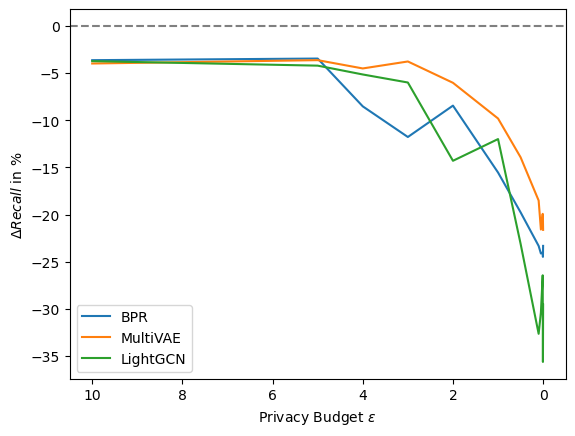

In [12]:
plt.plot(all_eps, delta_recall["BPR"], label="BPR")
plt.plot(all_eps, delta_recall["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_recall["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_recall["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_recall["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta Recall$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

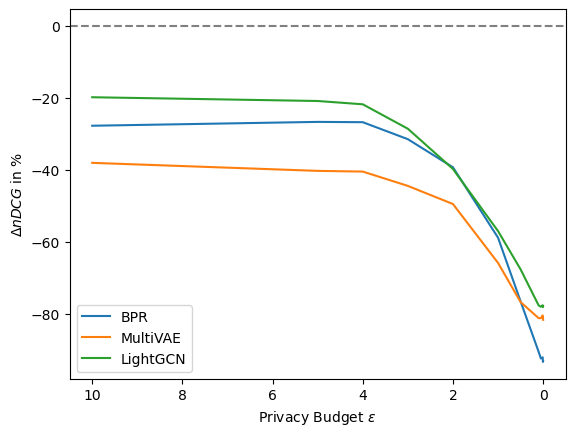

In [8]:
plt.plot(all_eps, delta_ndcg["BPR"], label="BPR")
#plt.plot(all_eps, delta_ndcg["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_ndcg["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_ndcg["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_ndcg["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta nDCG$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

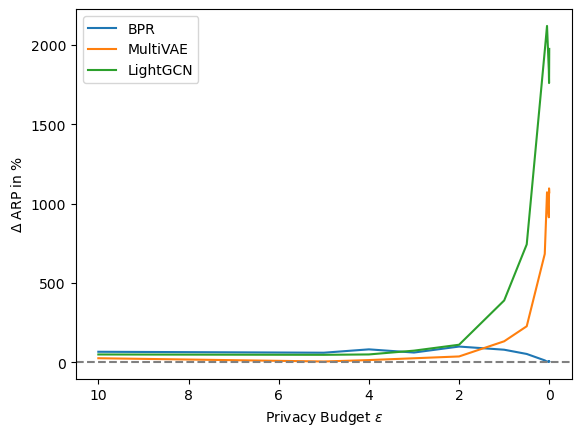

In [9]:
plt.plot(all_eps, delta_arp["BPR"], label="BPR")
#plt.plot(all_eps, delta_arp["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_arp["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_arp["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_arp["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ ARP in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

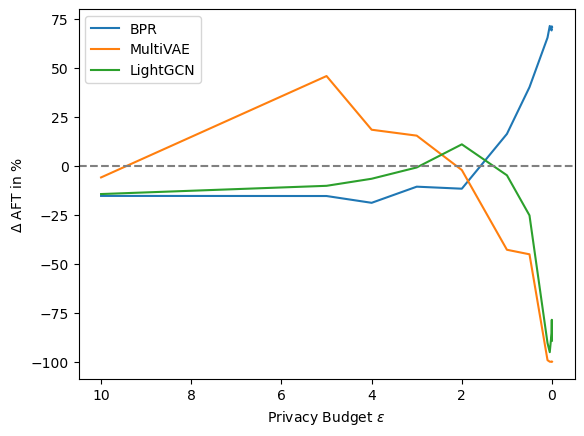

In [10]:
plt.plot(all_eps, delta_aft["BPR"], label="BPR")
#plt.plot(all_eps, delta_aft["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_aft["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_aft["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_aft["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ AFT in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

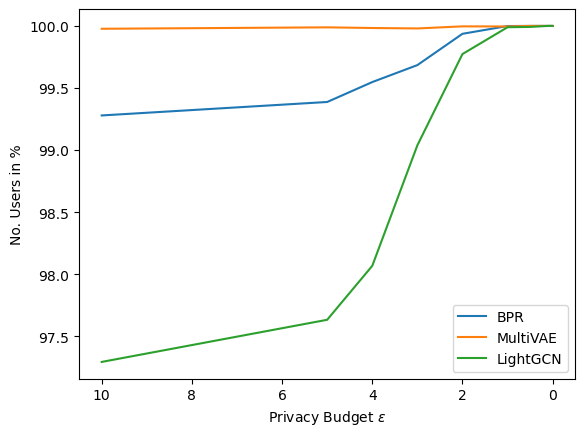

In [11]:
plt.plot(all_eps, no_users["BPR"], label="BPR")
#plt.plot(all_eps, no_users["NeuMF"], label="NeuMF")
plt.plot(all_eps, no_users["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, no_users["LightGCN"], label="LightGCN")
#plt.plot(all_eps, no_users["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("No. Users in %")
plt.gca().invert_xaxis()
plt.legend()

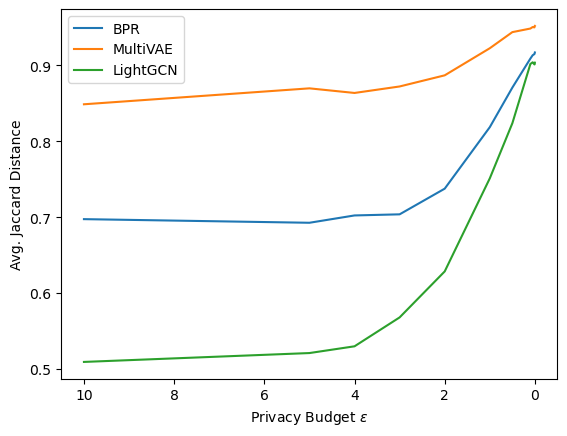

In [12]:
plt.plot(all_eps, jacc_dist["BPR"], label="BPR")
#plt.plot(all_eps, jacc_dist["NeuMF"], label="NeuMF")
plt.plot(all_eps, jacc_dist["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, jacc_dist["LightGCN"], label="LightGCN")
#plt.plot(all_eps, jacc_dist["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("Avg. Jaccard Distance")
plt.gca().invert_xaxis()
plt.legend()

In [13]:
dataset_name = "ml-1m"

test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
test_df["user_id"] = test_df["user_id"].astype(str)
test_df["item_id"] = test_df["item_id"].astype(str)

groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

cut = int(len(item_popularity) * 0.2)
head_items = set(item_popularity.sort_values(ascending=False).iloc[:cut].index.tolist())

frac_pop_items = df.groupby("user_id")["item_id"].apply(set).apply(lambda items: len(items.intersection(head_items)) / len(items))
frac_pop_items.name = "frac"

cut = int(len(frac_pop_items) * 0.2)
low_users = frac_pop_items.sort_values().head(cut).index.tolist()
high_users = frac_pop_items.sort_values().tail(cut).index.tolist()

In [30]:
def analyze_groups(dataset_name, model_name, groundtruth, item_popularity, group1, group2, absolute_values=False, compute_diff=True):
    def recgap(x, y):
        return np.abs(np.array(x) - np.array(y))

    def get_deltas(results_nodp, results_dp, abs=False):
        recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp
        recall_eps, ndcg_eps, arp_eps, aft_eps = results_dp

        delta_recall_eps, delta_ndcg_eps, delta_arp_eps, delta_aft_eps = [], [], [], []
        for file_idx in range(5):
            intersection = set(recall_nodp[file_idx].keys()).intersection(recall_eps[file_idx].keys())
            delta_recall_eps_f, delta_ndcg_eps_f, delta_arp_eps_f, delta_aft_eps_f = [], [], [], []
            for uid in intersection:
                if abs:
                    delta_recall_eps_f.append(recall_eps[file_idx][uid])
                    delta_ndcg_eps_f.append(ndcg_eps[file_idx][uid])
                    delta_arp_eps_f.append(arp_eps[file_idx][uid])
                    delta_aft_eps_f.append(aft_eps[file_idx][uid])
                else:
                    delta_recall_eps_f.append(100 * (recall_eps[file_idx][uid] - recall_nodp[file_idx][uid]) / recall_nodp[file_idx][uid] if recall_nodp[file_idx][uid] != 0 else np.nan)
                    delta_ndcg_eps_f.append(100 * (ndcg_eps[file_idx][uid] - ndcg_nodp[file_idx][uid]) / ndcg_nodp[file_idx][uid] if ndcg_nodp[file_idx][uid] != 0 else np.nan)
                    delta_arp_eps_f.append(100 * (arp_eps[file_idx][uid] - arp_nodp[file_idx][uid]) / arp_nodp[file_idx][uid] if arp_nodp[file_idx][uid] != 0 else np.nan)
                    delta_aft_eps_f.append(100 * (aft_eps[file_idx][uid] - aft_nodp[file_idx][uid]) / aft_nodp[file_idx][uid] if aft_nodp[file_idx][uid] != 0 else np.nan)
            delta_recall_eps.append(np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(np.nanmean(delta_aft_eps_f))

        return np.mean(delta_recall_eps), np.mean(delta_ndcg_eps), np.mean(delta_arp_eps), np.mean(delta_aft_eps)

    dir = "saved/" + dataset_name + "/" + model_name + "/"
    results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth)

    delta_recall1, delta_ndcg1, delta_arp1, delta_aft1 = [], [], [], []
    delta_recall2, delta_ndcg2, delta_arp2, delta_aft2 = [], [], [], []
    for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]:
        users, _, _ = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        group1_and_impacted, group2_and_impacted = [], []
        for users_s in users:
            group1_and_impacted.append(set([uid for uid in users_s]).intersection(group1))
            group2_and_impacted.append(set([uid for uid in users_s]).intersection(group2))

        results1_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=group1_and_impacted)
        results2_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=group2_and_impacted)

        delta_recall1_eps, delta_ndcg1_eps, delta_arp1_eps, delta_aft1_eps = get_deltas(results_nodp=results_nodp, results_dp=results1_eps, abs=absolute_values)
        delta_recall2_eps, delta_ndcg2_eps, delta_arp2_eps, delta_aft2_eps = get_deltas(results_nodp=results_nodp, results_dp=results2_eps, abs=absolute_values)

        delta_recall1.append(delta_recall1_eps)
        delta_ndcg1.append(delta_ndcg1_eps)
        delta_arp1.append(delta_arp1_eps)
        delta_aft1.append(delta_aft1_eps)

        delta_recall2.append(delta_recall2_eps)
        delta_ndcg2.append(delta_ndcg2_eps)
        delta_arp2.append(delta_arp2_eps)
        delta_aft2.append(delta_aft2_eps)

        if absolute_values:
            print("eps: %f -> %.2f/%.2f (recall), %.2f/%.2f (ndcg), %.2f/%.2f (arp), %.2f/%.2f (aft)" % (eps, delta_recall1[-1], delta_recall2[-1], delta_ndcg1[-1], delta_ndcg2[-1], delta_arp1[-1], delta_arp2[-1], delta_aft1[-1], delta_aft2[-1]))
        else:
            print("eps: %f -> %.2f%%/%.2f%% (recall), %.2f%%/%.2f%% (ndcg), %.2f%%/%.2f%% (arp), %.2f%%/%.2f%% (aft)" % (eps, delta_recall1[-1], delta_recall2[-1], delta_ndcg1[-1], delta_ndcg2[-1], delta_arp1[-1], delta_arp2[-1], delta_aft1[-1], delta_aft2[-1]))

    print()
    if compute_diff:
        print("Diff Recall: %s" % recgap(delta_recall1, delta_recall2))
        print("Diff nDCG: %s" % recgap(delta_ndcg1, delta_ndcg2))
        print("Diff ARP: %s" % recgap(delta_arp1, delta_arp2))
        print("Diff AFT: %s" % recgap(delta_aft1, delta_aft2))

        return (delta_recall1, delta_ndcg1, delta_arp1, delta_aft1), (delta_recall2, delta_ndcg2, delta_arp2, delta_aft2), (recgap(delta_recall1, delta_recall2), recgap(delta_ndcg1, delta_ndcg2), recgap(delta_arp1, delta_arp2), recgap(delta_aft1, delta_aft2))
    else:
        return (delta_recall1, delta_ndcg1, delta_arp1, delta_aft1), (delta_recall2, delta_ndcg2, delta_arp2, delta_aft2)

analyze_groups(dataset_name=dataset_name, model_name="BPR", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users, compute_diff=True)
analyze_groups(dataset_name=dataset_name, model_name="NeuMF", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users, compute_diff=True)
analyze_groups(dataset_name=dataset_name, model_name="LightGCN", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users,compute_diff=True)
analyze_groups(dataset_name=dataset_name, model_name="MultiVAE", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users, compute_diff=True)

C:\Users\pmuellner\AppData\Local\Temp\ipykernel_3556\3528255402.py:27: RuntimeWarning: Mean of empty slice
  delta_aft_eps.append(np.nanmean(delta_aft_eps_f))


eps: 10.000000 -> -7.09%/-2.02% (recall), -2.38%/0.91% (ndcg), -13.06%/-3.36% (arp), 26.78%/nan% (aft)
eps: 5.000000 -> -6.72%/-3.57% (recall), -1.49%/-0.24% (ndcg), -8.73%/-2.17% (arp), 16.13%/nan% (aft)
eps: 4.000000 -> -13.55%/-5.95% (recall), -7.54%/-2.74% (ndcg), 35.38%/1.29% (arp), -28.37%/nan% (aft)
eps: 3.000000 -> -15.62%/-9.70% (recall), -12.34%/-7.75% (ndcg), 39.36%/1.97% (arp), -21.18%/nan% (aft)
eps: 2.000000 -> -11.14%/-8.01% (recall), -5.35%/-4.56% (ndcg), 8.40%/-2.03% (arp), -34.19%/nan% (aft)
eps: 1.000000 -> -22.17%/-12.82% (recall), -15.40%/-9.46% (ndcg), 76.29%/3.66% (arp), -75.37%/nan% (aft)
eps: 0.500000 -> -24.87%/-17.84% (recall), -19.25%/-15.69% (ndcg), 77.79%/2.50% (arp), -83.96%/nan% (aft)
eps: 0.100000 -> -30.58%/-21.38% (recall), -24.68%/-19.07% (ndcg), 106.65%/4.33% (arp), -80.17%/nan% (aft)
eps: 0.050000 -> -32.24%/-20.66% (recall), -28.23%/-18.40% (ndcg), 106.52%/5.25% (arp), -88.49%/nan% (aft)
eps: 0.010000 -> -33.02%/-19.95% (recall), -27.09%/-16.56% (

(([-8.887106972225048,
   -7.952305282208856,
   -9.148563909981338,
   -6.146007984006836,
   -8.128562807879728,
   -14.26706920926066,
   -19.904357638322388,
   -24.3729935022048,
   -28.350666050647725,
   -26.121416279177414,
   -28.790378274189617,
   -28.380147951583105],
  [-5.188584500947451,
   -3.5693028757753824,
   -4.009887964903014,
   -0.46675048980854933,
   -1.4162311021236667,
   -6.484637593030689,
   -12.376398486614256,
   -14.644079763265495,
   -20.82070579833809,
   -16.71580674932289,
   -20.894056677507926,
   -19.10179383777261],
  [8.628481278661585,
   10.672889952308811,
   12.910096872509802,
   21.87563832663587,
   36.07107785270481,
   68.68241852776589,
   87.2454097426614,
   110.22966299210387,
   109.44967923190954,
   116.95615019519948,
   115.71743292974688,
   92.77174041723204],
  [-11.608330010230514,
   -19.706450463599094,
   -24.01529302611171,
   -43.60568404980285,
   -64.63488012675536,
   -86.70026880600103,
   -92.41252175472157,
  

In [110]:
def analyze_groups_gap(dataset_name, model_name, user_profile_pop, item_popularity, group1, group2, absolute_values=False, compute_diff=True):
    def get_deltas(gaps_nodp, gaps_eps, abs=False):
        delta_gap_eps = []
        for file_idx in range(5):
            intersection = set(gaps_nodp[file_idx].keys()).intersection(gaps_eps[file_idx].keys())
            delta_gap_eps_f = []
            for uid in intersection:
                if abs:
                    delta_gap_eps_f.append(gaps_eps[file_idx][uid])
                else:
                    delta_gap_eps_f.append(100 * np.abs(gaps_eps[file_idx][uid] - gaps_nodp[file_idx][uid]) / gaps_nodp[file_idx][uid] if gaps_nodp[file_idx][uid] != 0 else np.nan)
            delta_gap_eps.append(np.nanmean(delta_gap_eps_f))

        return np.mean(delta_gap_eps)
    print()
    print(model_name + " (" + dataset_name + ")")
    dir = "saved/" + dataset_name + "/" + model_name + "/"

    gaps_nodp = _compute_gap(dirpath=dir + "nodp", item_popularity=item_popularity, user_profile_popularity=user_profile_pop)
    print("No DP: %.2f/%.2f (delta gap)" % (results_per_group(gaps_nodp, [group1] * 5), results_per_group(gaps_nodp, [group2] * 5)))


    delta_gap1, delta_gap2 = [], []
    for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]:
        users, _, _ = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        group1_and_impacted, group2_and_impacted = [], []
        for users_s in users:
            group1_and_impacted.append(set([uid for uid in users_s]).intersection(group1))
            group2_and_impacted.append(set([uid for uid in users_s]).intersection(group2))

        gaps1_eps = _compute_gap(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, impacted_users=group1_and_impacted)
        gaps2_eps = _compute_gap(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, impacted_users=group2_and_impacted)
        delta_gap1_eps = get_deltas(gaps_nodp=gaps_nodp, gaps_eps=gaps1_eps, abs=absolute_values)
        delta_gap2_eps = get_deltas(gaps_nodp=gaps_nodp, gaps_eps=gaps2_eps, abs=absolute_values)

        delta_gap1.append(delta_gap1_eps)
        delta_gap2.append(delta_gap2_eps)

        if absolute_values:
            print("eps: %f -> %.2f/%.2f (delta gap)" % (eps, delta_gap1[-1], delta_gap2[-1]))
        else:
            print("eps: %f -> %.2f%%/%.2f%% (delta gap)" % (eps, delta_gap1[-1], delta_gap2[-1]))
    #print()
    if compute_diff:
        print("Diff Delta GAP: %s" % recgap(delta_gap1, delta_gap2))
        return delta_gap1, delta_gap2, recgap(delta_gap1, delta_gap2)
    else:
        return delta_gap1, delta_gap2

dataset_name = "ml-1m"
df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()
user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))

analyze_groups_gap(dataset_name=dataset_name, model_name="BPR", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)
analyze_groups_gap(dataset_name=dataset_name, model_name="NeuMF", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)
analyze_groups_gap(dataset_name=dataset_name, model_name="LightGCN", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)
analyze_groups_gap(dataset_name=dataset_name, model_name="MultiVAE", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)


BPR (ml-1m)
No DP: 1.52/1.06 (delta gap)
eps: 10.000000 -> 0.98/0.99 (delta gap)
eps: 5.000000 -> 1.08/1.01 (delta gap)
eps: 4.000000 -> 1.66/1.08 (delta gap)
eps: 3.000000 -> 2.03/1.09 (delta gap)
eps: 2.000000 -> 1.32/1.01 (delta gap)
eps: 1.000000 -> 2.33/1.13 (delta gap)
eps: 0.500000 -> 2.36/1.10 (delta gap)
eps: 0.100000 -> 2.72/1.14 (delta gap)
eps: 0.050000 -> 2.80/1.16 (delta gap)
eps: 0.010000 -> 2.79/1.13 (delta gap)
eps: 0.005000 -> 2.82/1.15 (delta gap)
eps: 0.001000 -> 2.86/1.16 (delta gap)
Diff Delta GAP: [0.00785955 0.06605795 0.58890241 0.93879371 0.31441778 1.20171111
 1.25691145 1.57989711 1.63705298 1.66536401 1.67620227 1.70076776]

NeuMF (ml-1m)
No DP: 0.94/0.81 (delta gap)
eps: 10.000000 -> 0.97/0.81 (delta gap)
eps: 5.000000 -> 0.99/0.83 (delta gap)
eps: 4.000000 -> 1.16/0.87 (delta gap)
eps: 3.000000 -> 1.05/0.85 (delta gap)
eps: 2.000000 -> 1.38/0.93 (delta gap)
eps: 1.000000 -> 1.93/1.02 (delta gap)
eps: 0.500000 -> 2.61/1.11 (delta gap)
eps: 0.100000 -> 2.6

([0.9718212827508479,
  0.9938921125886887,
  1.0200476449826996,
  1.1362976593635188,
  1.3073142285033388,
  1.6796890787098948,
  1.8803301089669204,
  2.1611437812196916,
  2.134656916750944,
  2.241535614528194,
  2.228949081989393,
  1.9289259149326217],
 [0.779690308706555,
  0.8032908502894974,
  0.7981272918206288,
  0.8367341450459836,
  0.8872857808706959,
  0.9366469070850219,
  0.955425599031184,
  1.0181085127570815,
  1.0168559758477158,
  1.04785735302316,
  1.05010863492426,
  0.9733835185631226],
 array([0.19213097, 0.19060126, 0.22192035, 0.29956351, 0.42002845,
        0.74304217, 0.92490451, 1.14303527, 1.11780094, 1.19367826,
        1.17884045, 0.9555424 ]))